0. 경로 설정

In [34]:
import os

os.getcwd()
base_dir = 'D:/Dacon_Art_Classification/Art_Classification'
data_dir = "D:/Dacon_Art_Classification/data"

1. Dataset 만들기

In [35]:
import torch
from torch.utils.data import DataLoader, Dataset,random_split
from torchvision import transforms
import torch.nn.functional as F
import pandas as pd
import numpy as np
import cv2

class CustomDataset(Dataset):
    
    def __init__(self, state,img_dir, label:pd.DataFrame=None, transform=None):
        self.state = state
        self.label = label
        self.img_dir = img_dir
        self.transform = transform
    def __len__(self):
        return len(self.label)
    def __getitem__(self, idx):
        # linux일때 '/' 바꿔서 돌리기
        if self.state =='train':
            img_path = os.path.join(self.img_dir,"train",self.label['img_path'][idx].split('/')[-1])
            img_label = self.label['artist'][idx]
            img = cv2.imread(img_path)
            if self.transform:
                img = self.transform(img)
                
            img_label = F.one_hot(torch.Tensor([img_label]).to(torch.int64),num_classes = 50)
            return img,img_label
        else:
            img_path = os.path.join(self.img_dir,"test",self.label['img_path'][idx].split('/')[-1])
            img = cv2.imread(img_path)
            if self.transform:
                img = self.transform(img)
            return img
train_label = pd.read_csv(f'{data_dir}/train.csv')
test_label = pd.read_csv(f'{data_dir}/test.csv')

label_dict = dict(zip(train_label['artist'].unique(),range(50)))
label_dict_decode = dict(zip(range(50),train_label['artist'].unique()))
print(label_dict)

train_label['artist'] = [label_dict[i] for i in train_label['artist']]

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)), 
    #transforms.RandomCrop(224),            
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),

])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
])


{'Diego Velazquez': 0, 'Vincent van Gogh': 1, 'Claude Monet': 2, 'Edgar Degas': 3, 'Hieronymus Bosch': 4, 'Pierre-Auguste Renoir': 5, 'Rene Magritte': 6, 'Michelangelo': 7, 'Peter Paul Rubens': 8, 'Caravaggio': 9, 'Alfred Sisley': 10, 'Edouard Manet': 11, 'Rembrandt': 12, 'Francisco Goya': 13, 'Pablo Picasso': 14, 'Titian': 15, 'Mikhail Vrubel': 16, 'Leonardo da Vinci': 17, 'Kazimir Malevich': 18, 'Andy Warhol': 19, 'Vasiliy Kandinskiy': 20, 'Gustav Klimt': 21, 'Amedeo Modigliani': 22, 'Henri Rousseau': 23, 'Salvador Dali': 24, 'Pieter Bruegel': 25, 'Albrecht Du rer': 26, 'Paul Gauguin': 27, 'Sandro Botticelli': 28, 'Piet Mondrian': 29, 'Eugene Delacroix': 30, 'Paul Klee': 31, 'William Turner': 32, 'Marc Chagall': 33, 'Jan van Eyck': 34, 'Henri Matisse': 35, 'El Greco': 36, 'Gustave Courbet': 37, 'Andrei Rublev': 38, 'Jackson Pollock': 39, 'Edvard Munch': 40, 'Camille Pissarro': 41, 'Raphael': 42, 'Henri de Toulouse-Lautrec': 43, 'Joan Miro': 44, 'Giotto di Bondone': 45, 'Diego Rivera'

In [36]:
img_label = F.one_hot(torch.Tensor([5]).to(torch.int64),num_classes = 50)
print(img_label)

tensor([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]])


In [37]:
Custom_data = CustomDataset('train',data_dir,train_label,train_transform)
train_set_size = int(len(Custom_data) * 0.8)
valid_set_size = int(len(Custom_data)-train_set_size )

train_set, valid_set = random_split(Custom_data, [train_set_size, valid_set_size])

train_dataloader = DataLoader(train_set, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_set, batch_size=32, shuffle=False)

test_data = CustomDataset('test',data_dir,test_label,test_transform)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

2. 모델 만들기

In [38]:
from torch import nn
from torchvision.models import resnet50, ResNet50_Weights

class ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        self.classifier = nn.Linear(1000, 50)

    def forward(self,x):
        x = self.backbone(x)
        x = self.classifier(x)
        x = torch.nn.functional.softmax(x,dim=0)
        return x


In [39]:
#from torchvision.models import resnet50, ResNet50_Weights
#import torch.nn as nn
#model_pretrained = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

#num_ftrs = model_pretrained.fc.in_features

#model_pretrained.fc = nn.Sequential(
#    nn.Linear(num_ftrs,200,bias=True),
#    nn.ReLU(inplace=True),
#    nn.Linear(200, 50),
#    nn.ReLU(inplace=True))
#print(model_pretrained)
#이거 쓰는 법도 공부해보기

In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet = ResNet()
resnet.to(device)
x = torch.randn(3, 3, 224, 224).to(device)
pretrained_output = resnet(x)
print(pretrained_output.size())

from torchsummary import summary
resnet.eval()
summary(resnet, (3, 224, 224), device=device.type)

torch.Size([3, 50])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-1

In [68]:
import torch.optim as optim
from tqdm import tqdm
print("start train")
#criterion = nn.MultiLabelSoftMarginLoss()
#criterion = nn.CrossEntropyLoss()
#criterion = nn.BCEWithLogitsLoss()
criterion = nn.BCELoss()
#optimizer = optim.SGD(pretrained_model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(resnet.parameters(), lr=0.00001)

num_epochs = 10
resnet.train()
# train_dataloader에 문제 발생한듯
loss_sum = []
for epoch in range(num_epochs):
    print("epoch is :",epoch)
    for i, (images,labels) in enumerate(tqdm(train_dataloader)):
        optimizer.zero_grad() # 1. optimizer 초기화

        images = images.to(device)
        labels = torch.tensor(labels).to(device)
        outputs = resnet(images)
        loss = criterion(outputs,labels.reshape(-1,50).float())
        loss_sum.append(loss)
        loss.backward()
        optimizer.step() 
    print(f'loss is : {loss}')

start train
epoch is : 0


  0%|                                                                                          | 0/148 [00:00<?, ?it/s]C:\Users\kimju\AppData\Local\Temp\ipykernel_30428\1227751227.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)
100%|████████████████████████████████████████████████████████████████████████████████| 148/148 [01:47<00:00,  1.38it/s]


loss is : 0.045055732131004333
epoch is : 1


100%|████████████████████████████████████████████████████████████████████████████████| 148/148 [01:56<00:00,  1.27it/s]


loss is : 0.03542036935687065
epoch is : 2


100%|████████████████████████████████████████████████████████████████████████████████| 148/148 [01:58<00:00,  1.25it/s]


loss is : 0.0385158397257328
epoch is : 3


100%|████████████████████████████████████████████████████████████████████████████████| 148/148 [01:58<00:00,  1.25it/s]


loss is : 0.03541179746389389
epoch is : 4


100%|████████████████████████████████████████████████████████████████████████████████| 148/148 [01:58<00:00,  1.25it/s]


loss is : 0.03295277804136276
epoch is : 5


100%|████████████████████████████████████████████████████████████████████████████████| 148/148 [01:57<00:00,  1.26it/s]


loss is : 0.04381118714809418
epoch is : 6


100%|████████████████████████████████████████████████████████████████████████████████| 148/148 [01:57<00:00,  1.26it/s]


loss is : 0.03609923645853996
epoch is : 7


100%|████████████████████████████████████████████████████████████████████████████████| 148/148 [01:58<00:00,  1.25it/s]


loss is : 0.039328135550022125
epoch is : 8


100%|████████████████████████████████████████████████████████████████████████████████| 148/148 [01:59<00:00,  1.24it/s]


loss is : 0.03504406660795212
epoch is : 9


100%|████████████████████████████████████████████████████████████████████████████████| 148/148 [01:59<00:00,  1.23it/s]

loss is : 0.04566306620836258


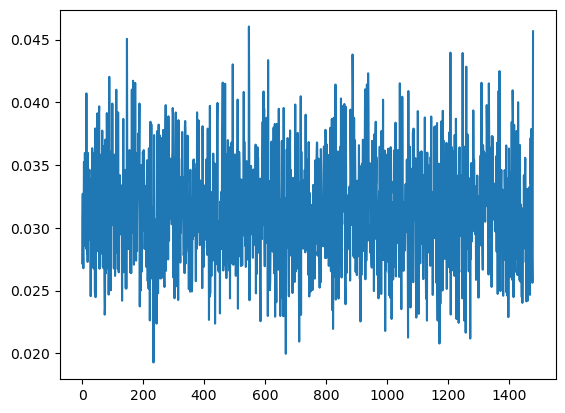

In [81]:
loss_plot = [i.item() for i in loss_sum]
import matplotlib.pyplot as plt
plt.plot(loss_plot)

In [44]:
torch.save(resnet,"pretrained_model.pt")

In [70]:
import torch
from tqdm import tqdm
from torchvision import transforms
test_data = CustomDataset('test',data_dir,test_label,test_transform)
test_dataloader = DataLoader(test_data, batch_size=16, shuffle=True)
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((300, 300)), 
    transforms.ToTensor(),
])
#valid_model = torch.load('model.pt')
valid_model = resnet
valid_model.eval()
out_list = []
label_list= []
with torch.no_grad():
    for i,(image,label) in enumerate(tqdm(valid_dataloader)):
        image = image.to(device)
        out = valid_model(image)
        out_list.append(out)
        label_list.append(label)

100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:26<00:00,  1.39it/s]


In [71]:
#print(len(label_list[0]))
k = [np.argmax(i,axis=2).flatten() for i in label_list]
final_label = []
for i in k:
    final_label+=i
final_label = [i.item() for i in final_label]
print(len(final_label))

1183


In [72]:
#final_label = []
#for i in label_list:
#    for j in i:
#        final_label.append(j.item())
#print(len(final_label))

In [73]:
final_class = [(i.argmax(axis=1).to('cpu')) for i in out_list]
final_output = []
for i in final_class:
    for j in i:
        final_output.append(j.item())
print(final_output)

[18, 35, 14, 14, 46, 29, 5, 3, 28, 15, 17, 25, 1, 27, 14, 6, 40, 27, 15, 4, 16, 22, 31, 23, 31, 5, 34, 3, 34, 5, 2, 33, 2, 31, 18, 3, 0, 13, 21, 27, 13, 15, 35, 11, 1, 16, 3, 3, 33, 47, 40, 1, 1, 1, 38, 10, 34, 5, 22, 46, 6, 17, 10, 1, 42, 49, 46, 35, 33, 14, 24, 30, 0, 8, 33, 2, 6, 3, 0, 1, 14, 21, 45, 25, 3, 28, 20, 5, 33, 16, 3, 48, 27, 31, 17, 12, 13, 12, 14, 3, 22, 13, 20, 31, 35, 33, 41, 3, 27, 43, 10, 3, 18, 47, 32, 6, 24, 28, 45, 12, 13, 36, 4, 16, 23, 6, 1, 13, 3, 38, 1, 29, 3, 13, 42, 15, 19, 5, 1, 33, 16, 6, 14, 14, 6, 33, 10, 11, 0, 15, 32, 1, 1, 3, 20, 19, 18, 22, 2, 17, 13, 15, 14, 5, 10, 31, 40, 3, 33, 20, 1, 47, 22, 12, 13, 19, 27, 25, 42, 19, 25, 15, 12, 1, 16, 41, 24, 12, 20, 43, 44, 5, 47, 1, 42, 14, 44, 26, 24, 38, 12, 48, 27, 44, 35, 13, 10, 6, 40, 14, 10, 19, 22, 4, 5, 3, 42, 26, 25, 26, 10, 11, 33, 15, 21, 26, 26, 5, 19, 27, 8, 3, 38, 22, 4, 10, 1, 10, 3, 1, 35, 12, 24, 4, 14, 6, 4, 2, 22, 39, 12, 23, 47, 0, 25, 29, 32, 16, 12, 19, 3, 1, 19, 45, 41, 39, 36, 5, 3,

In [74]:
from sklearn.metrics import f1_score
def competition_metric(true, pred):
    return f1_score(true, pred, average="macro")

In [75]:
score = competition_metric(final_label,final_output)

In [76]:
from sklearn.metrics import accuracy_score

accuracy_score(final_label,final_output)

0.7743026204564666

In [77]:
import torch
from tqdm import tqdm
from torchvision import transforms
test_data = CustomDataset('test',data_dir,test_label,test_transform)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
])
#valid_model = torch.load('model.pt')
test_model = resnet
test_model.eval()
model_preds = []
with torch.no_grad():
    for i,image in enumerate(tqdm(test_dataloader)):
        image = image.to(device)
        model_pred = test_model(image)
        model_preds += model_pred.argmax(1).detach().cpu().numpy().tolist()
print('Done')

100%|████████████████████████████████████████████████████████████████████████████████| 396/396 [02:20<00:00,  2.81it/s]

Done


In [82]:
submit = pd.read_csv(f'{data_dir}/sample_submission.csv')
submit['artist'] = model_preds
submit['artist'] = [label_dict_decode[i] for i in submit['artist']]
submit.to_csv('submission.csv', index=False)

In [79]:
print(model_preds)

[27, 22, 24, 26, 27, 35, 37, 10, 16, 1, 40, 13, 13, 22, 29, 23, 6, 28, 6, 3, 12, 6, 27, 15, 37, 5, 1, 6, 24, 44, 47, 44, 8, 35, 44, 3, 24, 19, 35, 18, 6, 38, 3, 12, 24, 27, 0, 13, 22, 3, 16, 4, 13, 25, 14, 21, 8, 26, 14, 26, 4, 27, 22, 26, 15, 3, 20, 12, 40, 22, 23, 26, 24, 16, 43, 1, 3, 27, 19, 1, 22, 4, 3, 10, 21, 16, 8, 27, 13, 22, 35, 13, 27, 35, 25, 16, 15, 1, 5, 3, 27, 1, 29, 12, 23, 3, 16, 40, 26, 26, 1, 16, 14, 35, 33, 8, 22, 27, 34, 18, 19, 22, 34, 12, 6, 8, 44, 10, 8, 12, 16, 13, 29, 14, 6, 26, 38, 3, 44, 25, 10, 13, 27, 33, 1, 3, 31, 27, 27, 1, 15, 12, 1, 24, 6, 34, 26, 27, 33, 26, 16, 1, 43, 28, 8, 16, 26, 24, 27, 31, 1, 15, 13, 27, 3, 16, 25, 26, 26, 13, 29, 29, 44, 13, 33, 3, 34, 26, 27, 15, 44, 23, 35, 1, 14, 33, 27, 27, 15, 16, 18, 44, 37, 1, 25, 3, 41, 21, 19, 10, 26, 15, 21, 26, 0, 33, 6, 6, 3, 3, 16, 22, 13, 1, 16, 35, 5, 10, 1, 1, 44, 16, 23, 27, 40, 3, 31, 19, 26, 35, 6, 27, 29, 33, 12, 22, 3, 3, 6, 13, 1, 1, 8, 24, 44, 4, 1, 28, 25, 13, 6, 37, 21, 16, 6, 31, 1, 10

In [80]:
label_dict_decode

{0: 'Diego Velazquez',
 1: 'Vincent van Gogh',
 2: 'Claude Monet',
 3: 'Edgar Degas',
 4: 'Hieronymus Bosch',
 5: 'Pierre-Auguste Renoir',
 6: 'Rene Magritte',
 7: 'Michelangelo',
 8: 'Peter Paul Rubens',
 9: 'Caravaggio',
 10: 'Alfred Sisley',
 11: 'Edouard Manet',
 12: 'Rembrandt',
 13: 'Francisco Goya',
 14: 'Pablo Picasso',
 15: 'Titian',
 16: 'Mikhail Vrubel',
 17: 'Leonardo da Vinci',
 18: 'Kazimir Malevich',
 19: 'Andy Warhol',
 20: 'Vasiliy Kandinskiy',
 21: 'Gustav Klimt',
 22: 'Amedeo Modigliani',
 23: 'Henri Rousseau',
 24: 'Salvador Dali',
 25: 'Pieter Bruegel',
 26: 'Albrecht Du rer',
 27: 'Paul Gauguin',
 28: 'Sandro Botticelli',
 29: 'Piet Mondrian',
 30: 'Eugene Delacroix',
 31: 'Paul Klee',
 32: 'William Turner',
 33: 'Marc Chagall',
 34: 'Jan van Eyck',
 35: 'Henri Matisse',
 36: 'El Greco',
 37: 'Gustave Courbet',
 38: 'Andrei Rublev',
 39: 'Jackson Pollock',
 40: 'Edvard Munch',
 41: 'Camille Pissarro',
 42: 'Raphael',
 43: 'Henri de Toulouse-Lautrec',
 44: 'Joan Mi